In [1]:
from data_loader import DataGenerator
from datetime import datetime
from model import model_builder
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau,
                                        ModelCheckpoint, TensorBoard)
from tensorflow.keras.models import load_model
from tensorflow.keras.backend import clear_session
import numpy as np
import warnings
from config import (model_config, data_generator_config, load_from_file,
                    n_epochs, model_name, tb_logs_path, model_checkpoint_file, test_seq_path)
from tensorflow.keras.losses import MSE, MAE
from tqdm import tqdm

In [8]:
def get_err_of_model(model, X, err_f, shape):
    preds = model.predict(X)
    errs = err_f(X.reshape(shape), preds.reshape(shape))
    err_of_mods = []
    for i, m_ix in enumerate(modifs_idx):
        if m_ix[0].shape[0] > 3 and m_ix[0].shape[0] < 50:
            err_of_mods.append(err_f(X[i, m_ix[0]].flatten(),
                                     preds[i, m_ix[0]].flatten()))
    overall_err = np.mean(errs)
    mods_err = np.mean(err_of_mods)
    return {"err": overall_err, "modifications_err": mods_err}

def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [3]:
data_generator_config['quality_threshold'] = 20.5
data_generator_config['test'] = True
data_generator_config['seq_path'] = test_seq_path
data_generator_config['load2ram'] = False
data_generator_config['step_len'] = 1028
data_generator_config

{'sample_len': 512,
 'batch_size': 1000,
 'quality_threshold': 20.5,
 'normalize': 'MEDIAN',
 'random_sample': True,
 'step_len': 1028,
 'load2ram': False,
 'test': True,
 'seq_path': '/tf/puc19/nanopore/MAP_Data/08_07_16_R9_pUC_BC/MA/downloads/pass/NB08/*.fast5'}

In [4]:
data_loader = DataGenerator(**data_generator_config)

/tf/puc19/nanopore/MAP_Data/08_07_16_R9_pUC_BC/MA/downloads/pass/NB08/*.fast5


In [5]:
X = []
modifs_idx = []
for _ in tqdm(range(20)):
    x, m_idx = next(data_loader)
    X.append(x)
    modifs_idx.append(m_idx)

 10%|█         | 2/20 [00:33<04:53, 16.29s/it]

unable to open file /tf/puc19/nanopore/MAP_Data/08_07_16_R9_pUC_BC/MA/downloads/pass/NB08/makeson_PC_20160809_FNFAD20242_MN17284_sequencing_run_MA_470_R9_pUC_g_PCR_BC_2_08_07_16_80510_ch180_read404_strand.fast5


 95%|█████████▌| 19/20 [05:23<00:17, 17.09s/it]

unable to open file /tf/puc19/nanopore/MAP_Data/08_07_16_R9_pUC_BC/MA/downloads/pass/NB08/makeson_PC_20160807_FNFAD20242_MN17284_sequencing_run_MA_470_R9_pUC_g_PCR_BC_08_07_16_93165_ch432_read1037_strand.fast5


100%|██████████| 20/20 [05:39<00:00, 16.95s/it]


In [6]:
X = np.array(X).reshape(20000, 512, 1)
modifs_idx = np.array(modifs_idx).reshape(20000, 1)

In [33]:
clear_session()
model = load_model(r"1711/model.01-0.01.h5")
print("MSE: ", get_err_of_model(model, X, MSE, (20000, 512)))
print("MAE: ", get_err_of_model(model, X, MAE, (20000, 512)))

MSE:  {'err': 0.009138081, 'modifications_err': 0.018486185}
MAE:  {'err': 0.06779552, 'modifications_err': 0.093310766}


In [34]:
clear_session()
model = load_model(r"1711/4_layers_CNN_m2e.h5")
print("MSE: ", get_err_of_model(model, X, MSE, (20000, 512)))
print("MAE: ", get_err_of_model(model, X, MAE, (20000, 512)))

MSE:  {'err': 0.0044917003, 'modifications_err': 0.007915976}
MAE:  {'err': 0.049509343, 'modifications_err': 0.064015985}


In [35]:
clear_session()
model = load_model(r"1711/model.08-0.00.h5")
print("MSE: ", get_err_of_model(model, X, MSE, (20000, 512)))
print("MAE: ", get_err_of_model(model, X, MAE, (20000, 512)))

MSE:  {'err': 0.0033834106, 'modifications_err': 0.0053430535}
MAE:  {'err': 0.04340319, 'modifications_err': 0.053596377}


In [85]:
modifs_idx[2]

array([array([402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414,
       415, 416, 417, 418, 419, 420, 421, 422, 423, 424])], dtype=object)

In [87]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 512, 64)           832       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 256, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 256, 32)           24608     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 128, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 128, 32)           12320     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 64, 32)            0     

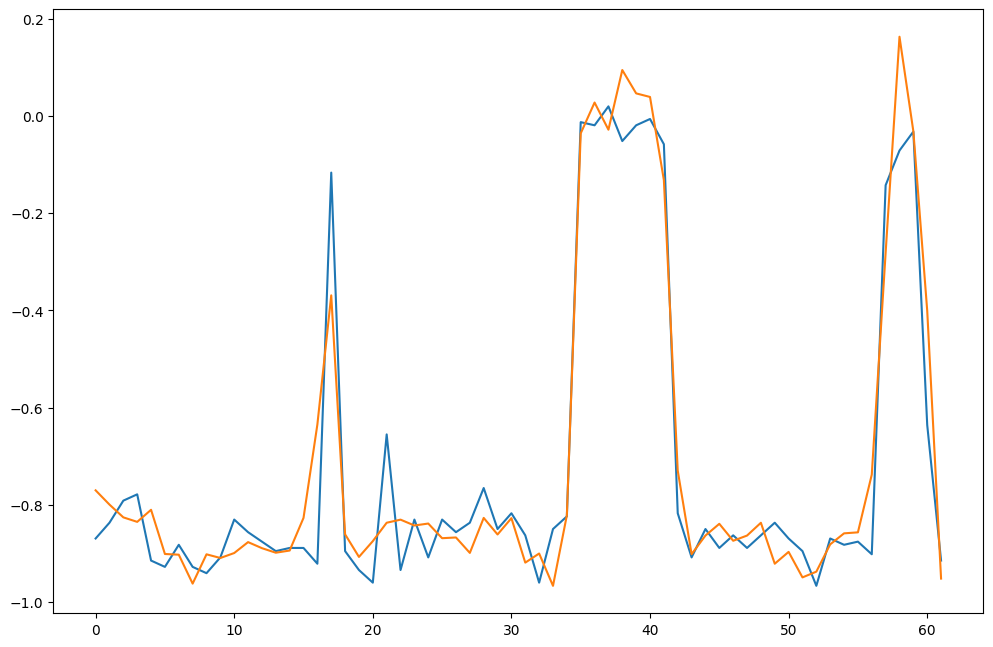

<Figure size 2000x2000 with 0 Axes>

In [91]:
from matplotlib import pyplot as plt
plt.plot(X[7, 450:].flatten())
plt.plot(preds[7, 450:].flatten())
plt.figure(figsize=(20,20))
# plt.rcParams['figure.figsize'] = [12, 8]
# plt.rcParams['figure.dpi'] = 100
plt.show()

In [40]:
preds = model.predict(X)

In [43]:
np.mean(MSE(X[0], preds[0]))

0.00252997

In [48]:
X[0].shape[0]

512

In [104]:
def get_roll_mses(signal, pred):
    roll_mses = []
    for idx in rolling_window(np.arange(signal.shape[0]), 25):
        roll_mses.append(np.median(MSE(signal[idx], pred[idx])))
    return np.array(roll_mses)

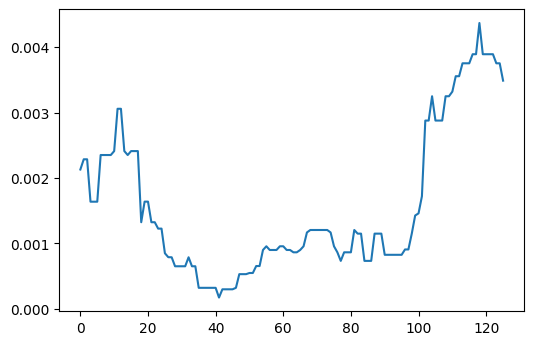

In [105]:
plt.plot(get_roll_mses(X[7, 150:300], preds[7, 150:300]))

plt.show()

In [108]:
np.array(MSE(X[7, 150:300],
         preds[7, 150:300]))

<tf.Tensor: shape=(150,), dtype=float32, numpy=
array([2.12867069e-03, 7.25227688e-03, 2.28495081e-03, 1.29949112e-04,
       1.43543890e-04, 4.14999085e-04, 1.22041602e-04, 1.63664913e-03,
       2.65700452e-04, 6.99553639e-05, 1.25745501e-04, 8.86665098e-03,
       2.10835896e-02, 4.04210063e-03, 2.35012290e-03, 3.41937481e-03,
       6.89561944e-04, 7.52412016e-03, 7.56040390e-04, 5.52864466e-03,
       3.56296706e-03, 7.37724476e-05, 4.16426919e-03, 2.44496507e-04,
       8.06984305e-03, 9.37097240e-03, 2.41038087e-03, 1.32282742e-03,
       3.15475954e-05, 3.43741995e-05, 2.93660127e-02, 2.53918861e-05,
       1.22514786e-03, 8.70785061e-06, 3.05710593e-03, 6.88729296e-03,
       2.95883790e-02, 7.86910416e-04, 5.85307498e-05, 1.28194010e-02,
       1.28313862e-02, 2.17540437e-05, 8.48357915e-04, 1.63777778e-03,
       2.11522728e-03, 5.50476070e-05, 5.37603664e-05, 6.05518289e-05,
       7.88418693e-04, 6.16654143e-05, 6.49493304e-04, 2.43486011e-05,
       4.03540544e-05, 7.8620

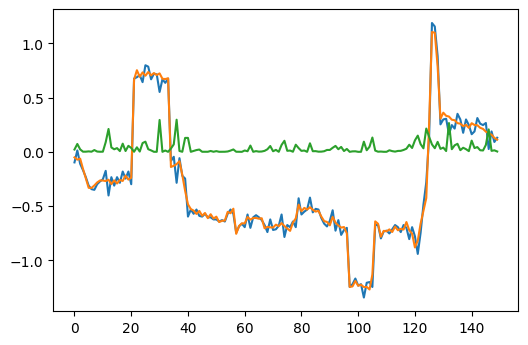

In [110]:
plt.plot(X[7, 150:300].flatten())
plt.plot(preds[7, 150:300].flatten())
plt.plot(np.array(MSE(X[7, 150:300],
         preds[7, 150:300])) * 10)
plt.show()

In [95]:
modifs_idx[:20]

array([[array([], dtype=int64)],
       [array([], dtype=int64)],
       [array([402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414,
       415, 416, 417, 418, 419, 420, 421, 422, 423, 424])],
       [array([], dtype=int64)],
       [array([], dtype=int64)],
       [array([], dtype=int64)],
       [array([], dtype=int64)],
       [array([256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268,
       269, 270, 271, 272, 273, 274, 427, 428, 429, 430, 431])],
       [array([], dtype=int64)],
       [array([], dtype=int64)],
       [array([], dtype=int64)],
       [array([], dtype=int64)],
       [array([], dtype=int64)],
       [array([], dtype=int64)],
       [array([83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95])],
       [array([ 56,  57,  58,  59,  60, 132, 133, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143, 327, 328, 329, 330])],
       [array([232, 233, 234, 235])],
       [array([], dtype=int64)],
       [array([], dtype=int64)],
       [array([

In [79]:
np.median(get_roll_mses(X[2], preds[2]))

0.003682124

In [80]:
np.median(get_roll_mses(X[-1], preds[-1]))

0.002750317

In [88]:
modifs_idx[:10]

array([[array([], dtype=int64)],
       [array([], dtype=int64)],
       [array([402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414,
       415, 416, 417, 418, 419, 420, 421, 422, 423, 424])],
       [array([], dtype=int64)],
       [array([], dtype=int64)],
       [array([], dtype=int64)],
       [array([], dtype=int64)],
       [array([256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268,
       269, 270, 271, 272, 273, 274, 427, 428, 429, 430, 431])],
       [array([], dtype=int64)],
       [array([], dtype=int64)]], dtype=object)